<a href="https://colab.research.google.com/github/Glifoyle/test-repo/blob/master/7_BERT_v4_sentiment_pre_trained_fugasi_unidic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 目的：日本語文章で感情分析
### 概要：日本語事前学習済みBERTモデルを活用して，文章から感情分析（ポジティブ・ネガティブ分析）を実践する．

<br>
&copy; 2021-2024 Hiro Kimura
<br>








## ポイント：

- 日本語の処理環境の構築
1. 形態素解析ツールのインストー
1. ライブラリのインポート

- BERTの利用環境の構築
1. モデルの定義
1. ポジティブ・ネガティブ判定（推論）パイプライン


# 実習の準備

1. GPUの確認
1. タイムゾーンを東京に設定する
1. Google Driveをマウントする
2. 作業用フォルダを作成する
1. ライブラリのインストール
  - HuggingFace transformers
3. 作業用フォルダに感情分析データファイルをアップロードする



## GPU/CPUの設定を確認する

In [ ]:
# CPU / GPU の設定
import torch

# GPUの設定であればcuda，そうでなければcpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
# # 割り当てられたGPUを確認する

if device == "cuda":
  ! nvidia-smi
  ! torch.cuda.get_device_name(0)
else:
  print(device)

# !nvidia-smi

cpu


In [ ]:
# # 割り当てられたGPUの機種を調べる
# torch.cuda.get_device_name(0)

'Tesla T4'

## タイムゾーンを東京に変更する

In [ ]:
!date

Sun Jul 21 11:49:40 PM UTC 2024


In [ ]:
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Asia/Tokyo /etc/localtime

In [ ]:
!date

Mon Jul 22 08:49:45 AM JST 2024


## Google Driveをマウントする


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# google driveのフォルダの中身を確認する
# ! pwd
! ls -F /content/drive/'My Drive'/practice


2023_important/  chap_diffusion/  chap_gan/  chap_gradcam/  chap_vit/
chap_ae/	 chap_dqn/	  chap_gpt/  chap_vae/	    chap_w2v/


In [ ]:
# 作業用フォルダを作成
import os

chap_dir = "/content/drive/MyDrive/practice/chap_bert"
if not os.path.exists(chap_dir):
    # os.mkdir(chap_dir)
    os.makedirs(chap_dir)

os.chdir(chap_dir)
os.getcwd()

'/content/drive/MyDrive/practice/chap_bert'

# ライブラリをインストールする
- HuggingFace Transformers
  - BERTを利用するためのライブラリー
- 適応できるタスク
  - 検索
  - 文章分類
  - 文章生成
  - 質問応答
  - 文章要約
  - 固有表現抽出
  - 他

In [ ]:
# # インストール可能なバージョン番号を確認する
# ! pip install transformers==

In [ ]:
# transformers
# ! pip install transformers # 最新版（4.24.0）はBertJapaneseTokenizerがインストールできない（2022.11.8）
# ! pip install transformers==4.42.4
! pip install transformers

In [ ]:
# # 動作確認（英語文章レベル）
# from transformers import pipeline

# classifier = pipeline('sentiment-analysis')
# results = classifier(["We are very happy to show you the 🤗 Transformers library.",
#            "We hope you don't hate it."])
# for result in results:
#     print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

# 形態素解析（日本語処理）ツールをインストールする
- fugashi（Mecabのラッパー）
  - Mecab（形態素解析エンジン：自動的に入る）
- UniDic辞書（Fugashiが使用する語彙データ辞書）
  - IPAdic（Mecabが使用する語彙データ辞書，2007年まで更新された）

### fugashi

In [ ]:
# fugashi
!pip install fugashi # ipadicが必要
# !pip install 'fugashi[unidic-lite]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 5.7 MB/s eta 0:00:00


### IPAdic

In [ ]:
# IPAdic
!pip install ipadic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=1bb8e45223ce910046c73ca9dcc5bf48dc7872de29d4b575c69b0e66718e88b4
  Stored in directory: /root/.cache/pip/wheels/5b/ea/e3/2f6e0860a327daba3b030853fce4483ed37468bbf1101c59c3
Successfully built ipadic


# 日本語BERTの動作確認




## 日本語トークナイザの動作を確認する

In [ ]:
from transformers import BertJapaneseTokenizer

# 事前学習済み日本語BERTモデル + 日本語トークナイザ
BERT_MODEL = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = BertJapaneseTokenizer.from_pretrained(BERT_MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/258k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

In [ ]:
# 日本語のテキストを入力する
text = '今日は快晴だ．[MASK]が輝いている．'

# テキストをトークン（単語）に分割する
tokens = tokenizer.tokenize(text)

print(tokens)
print(len(tokens))

['今日', 'は', '快', '##晴', 'だ', '.', '[MASK]', 'が', '輝い', 'て', 'いる', '.']
12


In [ ]:
print(tokens[0])
print(len(tokens[0]))

今日
2


In [ ]:
# トークンをIDに変換して取得する（pytorchのテンソルとして）
token_ids = tokenizer.encode(text, return_tensors='pt')

print(token_ids)
print(len(token_ids[0]))

tensor([[    2,  3246,     9,  3265, 29956,    75,   143,     4,    14, 10906,
            16,    33,   143,     3]])
14


In [ ]:
# トークンID列を文字に逆変換する
# 先頭に[CLS]、文末に[SEP]が追加されていることが分かる
token_rev = tokenizer.convert_ids_to_tokens(token_ids[0])

print(token_rev)
print(len(token_rev))

['[CLS]', '今日', 'は', '快', '##晴', 'だ', '.', '[MASK]', 'が', '輝い', 'て', 'いる', '.', '[SEP]']
14


# Masked Language Modelの動作を確認する

- 穴埋め問題をやってみる

In [ ]:
from transformers import BertForMaskedLM

# Masked LM
masklm_model = BertForMaskedLM.from_pretrained(BERT_MODEL)

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# トークンIDをモデルに入力して推論する

with torch.no_grad():
    output = masklm_model(input_ids = token_ids)
    scores = output.logits

print(scores.shape)

torch.Size([1, 14, 32000])


In [ ]:
# 32000個のVocabularyの最初の50個を表示してみる

first50_tokens = tokenizer.convert_ids_to_tokens(list(range(50)))

print(first50_tokens)

['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', 'の', '、', 'に', '。', 'は', 'た', 'を', 'で', 'と', 'が', 'し', 'て', '1', 'な', '年', 'れ', 'い', 'あ', '(', ')', '2', 'さ', 'こ', 'も', 'か', '##する', 'ある', '日', 'いる', 'する', '・', '「', '月', '」', '19', 'から', '20', '大', 'ア', 'そ', 'こと', '##して', 'ま', '3', 'や']


In [ ]:
# [MASK]（id=4）のテキスト内での位置を求める

mask_position = token_ids[0].tolist().index(4)
print(mask_position)

7


In [ ]:
# [MASK]位置のscore値が大きいものを10個

top10 = scores[0, mask_position].topk(20) # topk()はpytorchで定義

# 10個のインデックスをテキストのトークンに変換する。
pred10tokens = tokenizer.convert_ids_to_tokens(top10.indices)

print(text+"\n")
print(pred10tokens)

今日は快晴だ．[MASK]が輝いている．

['星', '太陽', '朝日', '光', '月', '神', '平和', '金', 'ダイヤモンド', '栄光', '人', '勝利', '黄金', '人々', '灯台', '大統領', '金星', '女神', '名誉', '獅子']


In [ ]:
# [MASK]の位置でスコア最大のインデックスをピンポイントで取得

# top_idx = scores[0, mask_position].argmax(-1).item()
top_idx = scores[0, mask_position].argmax().item()
top_token = tokenizer.convert_ids_to_tokens(top_idx)
print(top_token)

星


# 感情分析（ポジティブ・ネガティブ判定）を行う

- pipeline("sentiment-analysis")を使用してみる
- ファインチューニング済み公開モデルを利用してみる

In [ ]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification

# 感情分析用の事前学習済み日本語BERTモデル
# model = AutoModelForSequenceClassification.from_pretrained('daigo/bert-base-japanese-sentiment') # 利用不可@2024
model = AutoModelForSequenceClassification.from_pretrained('koheiduck/bert-japanese-finetuned-sentiment') #

# ポジティブ・ネガティブ判定器（pipelineアプリを使用）
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


config.json:   0%|          | 0.00/924 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [ ]:
# 動作確認テストデータ
TARGET_TEXT = "日本語文章から感情分析ができます．気になる文章を入力して試してください．"

print(nlp(TARGET_TEXT))

[{'label': 'POSITIVE', 'score': 0.8867710828781128}]


## 収集したデータを分析する
 - データファイルから
  - 作業ディレクトリに配置する
    - Excelファイル
    - CSVファイル


# データファイルを読み込む

- 回答_2極.csv をアップロードする

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving 回答_2極.csv to 回答_2極.csv


In [ ]:
!ls -l

total 14
-rw------- 1 root root 14113 Jul 22 09:07 回答_2極.csv


In [ ]:
import pandas as pd

# Excelファイルからデータフレームに読み込む
# in_file = "enquete.xlsx"
# in_file = "opinion.xlsx"
# in_file = "回答_2極.xlsx"
in_file = "回答_2極.csv"

# df = pd.read_excel(in_file) # 全て読み込む
# df = pd.read_excel(in_file, na_filter=False) # データが無いも（NaN）のは読み込まない
# df = pd.read_excel(in_file, header=1, na_filter=False) # データが無いも（NaN）のは読み込まない，一行目をヘッダとして
df = pd.read_csv(in_file, header=1, na_filter=False) # データが無いも（NaN）のは読み込まない，一行目をヘッダとして/

print(df.shape)

(212, 7)


In [ ]:
# 表示して確認する
df.head()

,回答,ラベル,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,今週の試験は頑張るぞ．,1,,,,,
1,今日は調子が良さそうだ．,1,,,,,
2,何でもできそうな気がする．,1,,,,,
3,今日は役満をあがった,1,,,,,
4,今日は調子がいい,1,,,,,


In [ ]:
# 列名を確認する
df.columns

Index(['回答', 'ラベル', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6'],
      dtype='object')

## 感情分析をする

In [ ]:
# 意見感想を抜き出す
# targets = df["意見感想"] # enquete
# targets = df["意見（その他）"] # opinion
targets = df["回答"] # 回答

print(targets)
print(type(targets))

0                      今週の試験は頑張るぞ．
1                     今日は調子が良さそうだ．
2                    何でもできそうな気がする．
3                       今日は役満をあがった
4                         今日は調子がいい
                  ...             
207    接客態度悪いし味もいまいち。もうこの店には来たくない。
208                   今日は部活に行きたくない
209                自分の時間が無くなって、最悪だ
210                 もう、絶対無理。負けちゃう。
211                 渋滞にはまっていらいらするわ
Name: 回答, Length: 212, dtype: object
<class 'pandas.core.series.Series'>


In [ ]:
# ポジティブ・ネガティブ判定をする（推論）

ans = []
labels = []
scores = []
for target in targets:
  if target == "" : continue
  result = nlp(target)[0] # 判定（推論）
  ans.append(target)
  lab = 0
  if result['label'] == "POSITIVE":
    lab = 1
  labels.append(lab) # 1 <- "ポジティブ"，0 <- "ネガティブ"
  scores.append(f'{result["score"]:.2f}')
  # print(result["label"], f'{result["score"]:.2f}')

print("labels:\n", labels)
print("scores:\n", scores)


labels:
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
scores:
 ['0.97', '0.87', '0.72', '0.79', '0.98', '0.97', '0.76', '0.97', '0.99', '0.92', '0.98', '0.99', '0.99', '0.97', '0.93', '0.99', '0.98', '0.51', '0.88', '0.99', '0.96', '0.96', '0.99', '0.99', '0.99', '0.99', '0.90', '0.99', '0.96', '0.98', '0.99', '0.98', '0.96', '0.94', '0.98', '0.98', '0.99', '0.96', '0.99', '0.96', '0.58', '0.98', '0.86', 

## 結果をファイルに格納する

In [ ]:
# データフレームに列を追加する
# df_o = pd.DataFrame(ans, columns=["意見感想"]) # enquete
# df_o = pd.DataFrame(ans, columns=["意見（その他）"]) # opinion
df_o = pd.DataFrame(ans, columns=["回答"]) # 回答
# df["ans"] = ans
df_o["teacher"] = df["ラベル"]
df_o["labels"] = labels
df_o["scores"] = scores

# shapeを確認する
print(df_o.shape)

# 内容を確認する
print(df_o.tail())

(212, 4)
                              回答  teacher  labels scores
207  接客態度悪いし味もいまいち。もうこの店には来たくない。        0       0   1.00
208                 今日は部活に行きたくない        0       0   0.98
209              自分の時間が無くなって、最悪だ        0       0   0.99
210               もう、絶対無理。負けちゃう。        0       0   0.99
211               渋滞にはまっていらいらするわ        0       0   0.96


In [ ]:
# ファイルに出力する
out_file = "sentiment_pre-trained_posi-nega_" + in_file
# df_o.to_excel(out_file, index=False)
df_o.to_csv(out_file, index=False)

In [ ]:
# ファイルを確認する
!ls -l

total 28
-rw------- 1 root root 14320 Jul 22 09:12 sentiment_pre-trained_posi-nega_回答_2極.csv
-rw------- 1 root root 14113 Jul 22 09:07 回答_2極.csv


## 予測性能を評価する

In [ ]:
# 予測性能の評価
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# 元データは数値
y_t_list = df_o["teacher"].values

# 元データは文字 => 数値に
y_p_list = df_o["labels"].values.astype(np.int64)


In [ ]:
# 混同行列
cm = confusion_matrix(y_t_list, y_p_list)


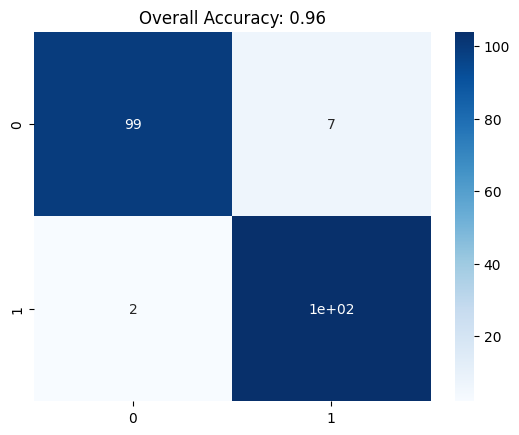

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

acc = accuracy_score(y_t_list, y_p_list)
title="Overall Accuracy: {:.2f}".format(acc)
plt.title(title, fontsize=12)

sns.heatmap(cm, annot=True, cmap='Blues')

plt.savefig('./posi-nega_cm.png')
plt.show()

In [ ]:
# 混同行列から基本的な評価指標を得る
tn, fp, fn, tp = confusion_matrix(y_t_list, y_p_list).ravel()
print('TN（True Negative）：{}, FP（False Positive）：{}, \nFN（False Negative）：{}, TP（True Positive）：{}\n'.format(tn, fp, fn, tp))

# 評価指標を計算する
Accuracy = (tp+tn)/(tp+fp+tn+fn) # 正解率
Recall = Sensitivity = TPR = (tp)/(tp+fn) # 感度
Specificity = TNR = (tn)/(tn+fp) # 特異度
FPR = (fp)/(tn+fp) # 1 - 特異度
Precision = PPV = (tp)/(fp+tp) # 陽性的中率
NPV = (tn)/(tn+fn) # 陰性的中率
F1_score = 2*Recall*Precision / (Recall + Precision) #F1-Score RecallとPrecisionの調和平均

print('全体の正解率：{:.2f}'.format(Accuracy))
print('\n真の値から見た評価指標（分母が真の値）：')
print('\tSensitivity（感度）Recall（再現率）TPR（真陽性率）：{:.2f}'.format(TPR))
print('\tSpecificity（特異度）TNR（真陰性率）：{:.2f}'.format(TNR))
print('\tFPR（偽陽性率）：{:.2f}'.format(FPR))
print('\n予測値から見た評価指標（分母が予測値）：')
print('\tPrecision（適合率）PPV（陽性的中率）：{:.2f}'.format(PPV))
print('\tNPV（陰性的中率）：{:.2f}'.format(NPV))
print('\n総合評価指標：')
print('\tF1-score：{:.2f}'.format(F1_score))

TN（True Negative）：99, FP（False Positive）：7, 
FN（False Negative）：2, TP（True Positive）：104

全体の正解率：0.96

真の値から見た評価指標（分母が真の値）：
	Sensitivity（感度）Recall（再現率）TPR（真陽性率）：0.98
	Specificity（特異度）TNR（真陰性率）：0.93
	FPR（偽陽性率）：0.07

予測値から見た評価指標（分母が予測値）：
	Precision（適合率）PPV（陽性的中率）：0.94
	NPV（陰性的中率）：0.98

総合評価指標：
	F1-score：0.96


In [ ]:
# from sklearn.metrics import classification_report

# # scikit-learn
# print(classification_report(y_t_list, y_p_list))

# 発展課題：自分のデータで感性分析（ポジ・ネガ判定）
1. 分析したい文章をExcelの列データにまとめる
1. Excelファイルまたはcsvファイルに書き出す
1. プログラムでファイルを読み込む
1. 「感情分析（ポジティブ・ネガティブ判定）を行う」を参考に分析する





# まとめ
- 日本語文章を扱うための環境を構築した
  - 日本語コーパスで事前学習済みBERTモデルを用いた
  - 日本語に対応したトークナイザを用いた
    - 形態素解析ツールを用いた
- 日本語文章から感情分析を行った
  - 学習済みのポジティブ・ネガティブ判定器を用いた
  - 自分たちで収集したデータを判定した